In [15]:
import OleFileIO_PL
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
from matplotlib.pyplot import figure
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')


In [30]:
def read_excel(file):

    # open the xls file
    read_xls = open(file,'rb')
    ole_f = OleFileIO_PL.OleFileIO(read_xls)
    d = ole_f.openstream('Workbook')
    
    # read this file with pandas
    df = pd.read_excel(d,engine='xlrd')

    # Removing excel stufs
    df = df.drop([0,1,2]).reset_index(drop=True)

    return df

def preparing_data(df, columns):
    
    # Replacing column names
    df.columns = columns
    
    # Change object columns with values to float
    df[columns[3]] = df[columns[3]].astype('float64')
    df[columns[4]] = df[columns[4]].astype('float64')
    df[columns[5]] = df[columns[5]].astype('float64')

    return df 

def create_month_year(df, month_name, year_name):        
    
    # Create values_month 
    months_to_replace = {}
    value_month = 1
    for month in df[month_name].unique():
        months_to_replace[month] = value_month
        value_month+=1 

    # Replacing month name to month value
    df[month_name] = df[month_name].map(months_to_replace)

    # Creating month_year column
    df['month_year'] = df[year_name].astype('str')+'-'+df[month_name].astype('str')
    df['month_year'] = pd.to_datetime(df['month_year'])
    
    # Transforming month_year in index
    df = df.set_index('month_year')

    return df 

def create_analytical_columns(df, column_based, state, column_state):

    df = df[df[column_state]==state]
    
    df['accumulated_sum_of_price'] = df[column_based].cumsum()
    df['diff_of_price'] = df[column_based].diff()
    df['moving_average_3m'] = df[column_based].rolling(window = 3).mean()
    df['moving_average_5m'] = df[column_based].rolling(window = 5).mean()
    
    results = seasonal_decompose(df[column_based])
    df['seasonal'] = results.seasonal
    df['trend'] = results.trend

    return df


def plot_timeseries(df, column_name='', states=[], plot_value='', title='', x_axis='', y_axis=''):
    
    sns.set_style('darkgrid')
    figure(figsize=(20, 15), dpi=100)
    plt.title(f'{title}',fontsize=24)
    plt.xlabel(f'{x_axis}',fontsize=24)
    plt.ylabel(f'{y_axis}',fontsize=24)
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)

    for state in states:
        df[df[column_name]==state][plot_value].plot()
        plt.legend(states)
    
    return plt.show()

In [31]:
file = 'C:/Users/felip/Downloads/CEPEA_20220825204450.xls'

columns = ['year', 'month', 'state', 'lowest average price', 'average price', 'highest average price']


df = create_month_year(
            preparing_data(
                read_excel(
                    file)
                ,columns)
    ,month_name='month', year_name='year')

df

,year,month,state,lowest average price,average price,highest average price
month_year,,,,,,
2005-01-01,2005,1,RS,0.4090,0.4796,0.5153
2005-01-01,2005,1,PR,0.3962,0.4806,0.5269
2005-01-01,2005,1,SP,0.4177,0.5109,0.5525
2005-01-01,2005,1,MG,0.4299,0.4939,0.5410
2005-01-01,2005,1,GO,0.4093,0.4862,0.5234
...,...,...,...,...,...,...
2022-07-01,2022,7,GO,2.8176,3.3575,3.4925
2022-07-01,2022,7,BA,2.4876,2.6878,3.1072
2022-07-01,2022,7,BRASIL,2.8361,3.1932,3.3728


In [32]:
df[df['average price']==0]['state'].unique()

array(['PE', 'MS', 'CE'], dtype=object)

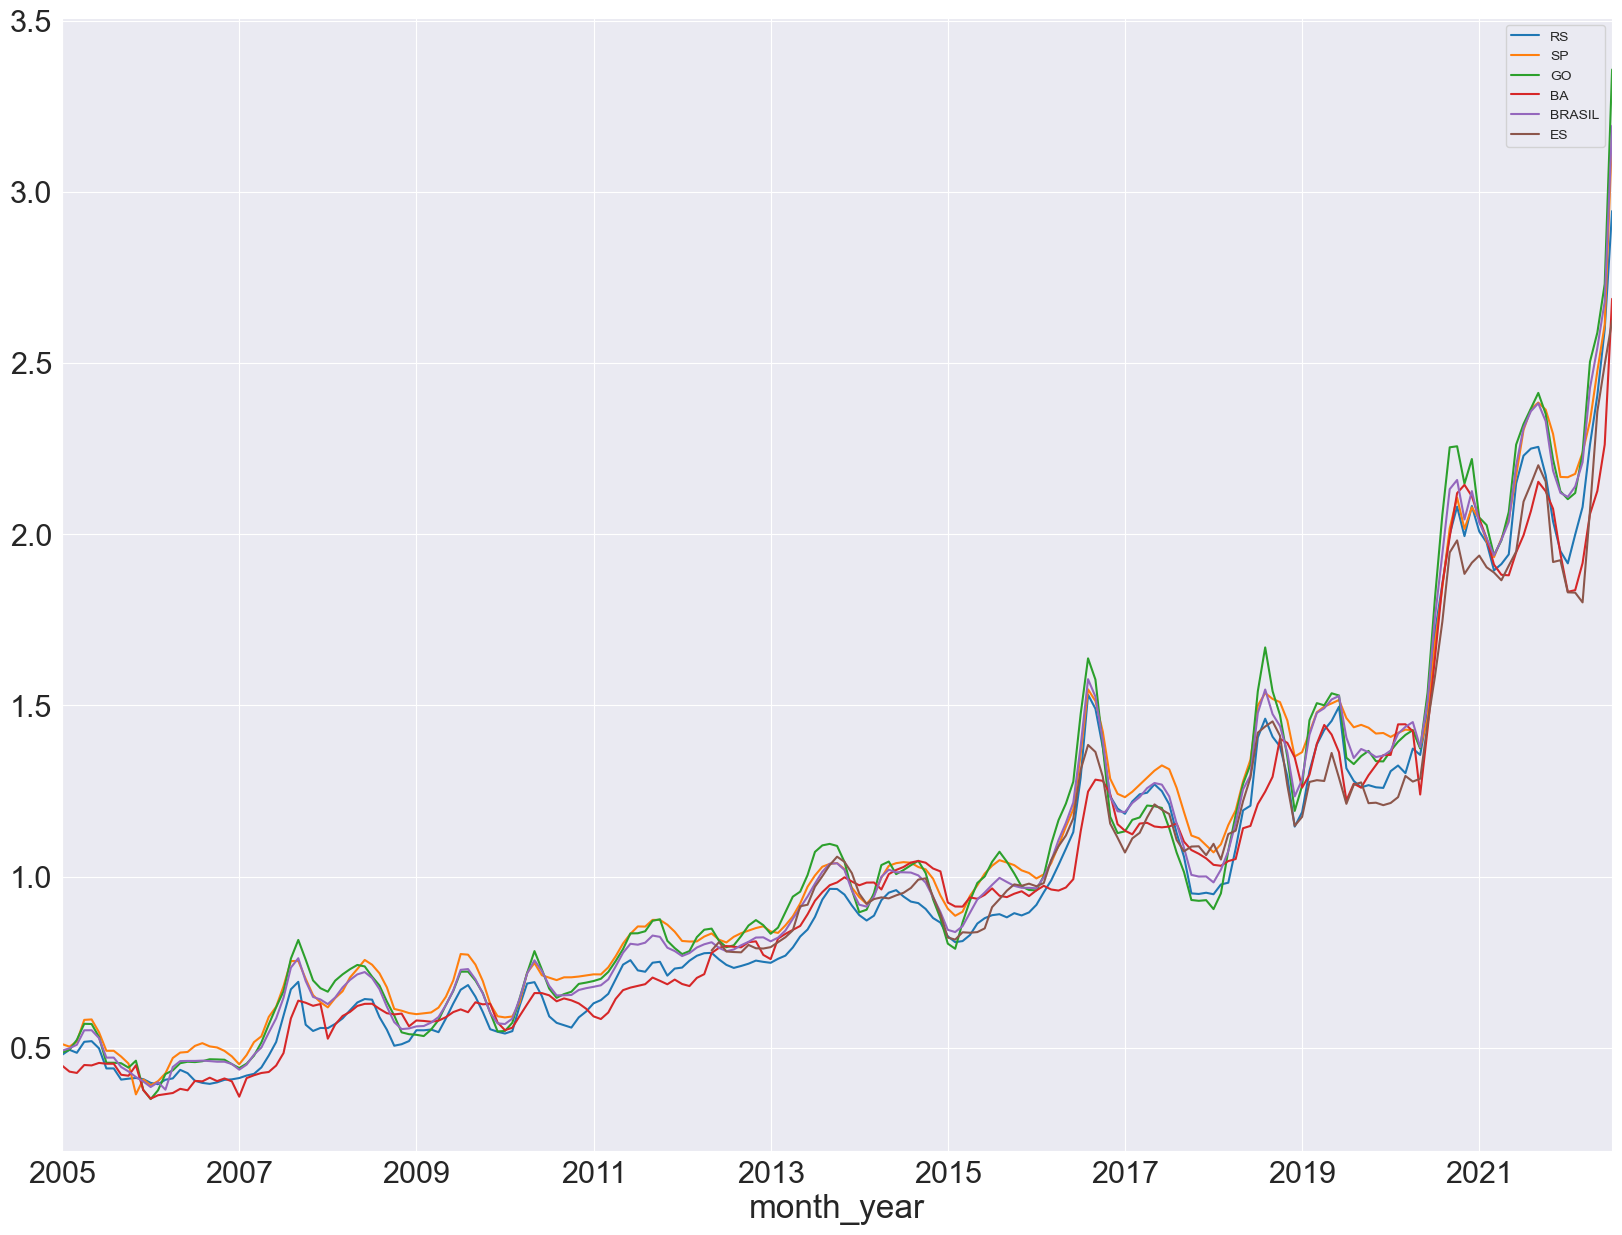

In [33]:
plot_timeseries(df,\
    states=['RS', 'SP', 'GO', 'BA', 'BRASIL', 'ES'],\
         plot_value='average price',\
             column_name='state')

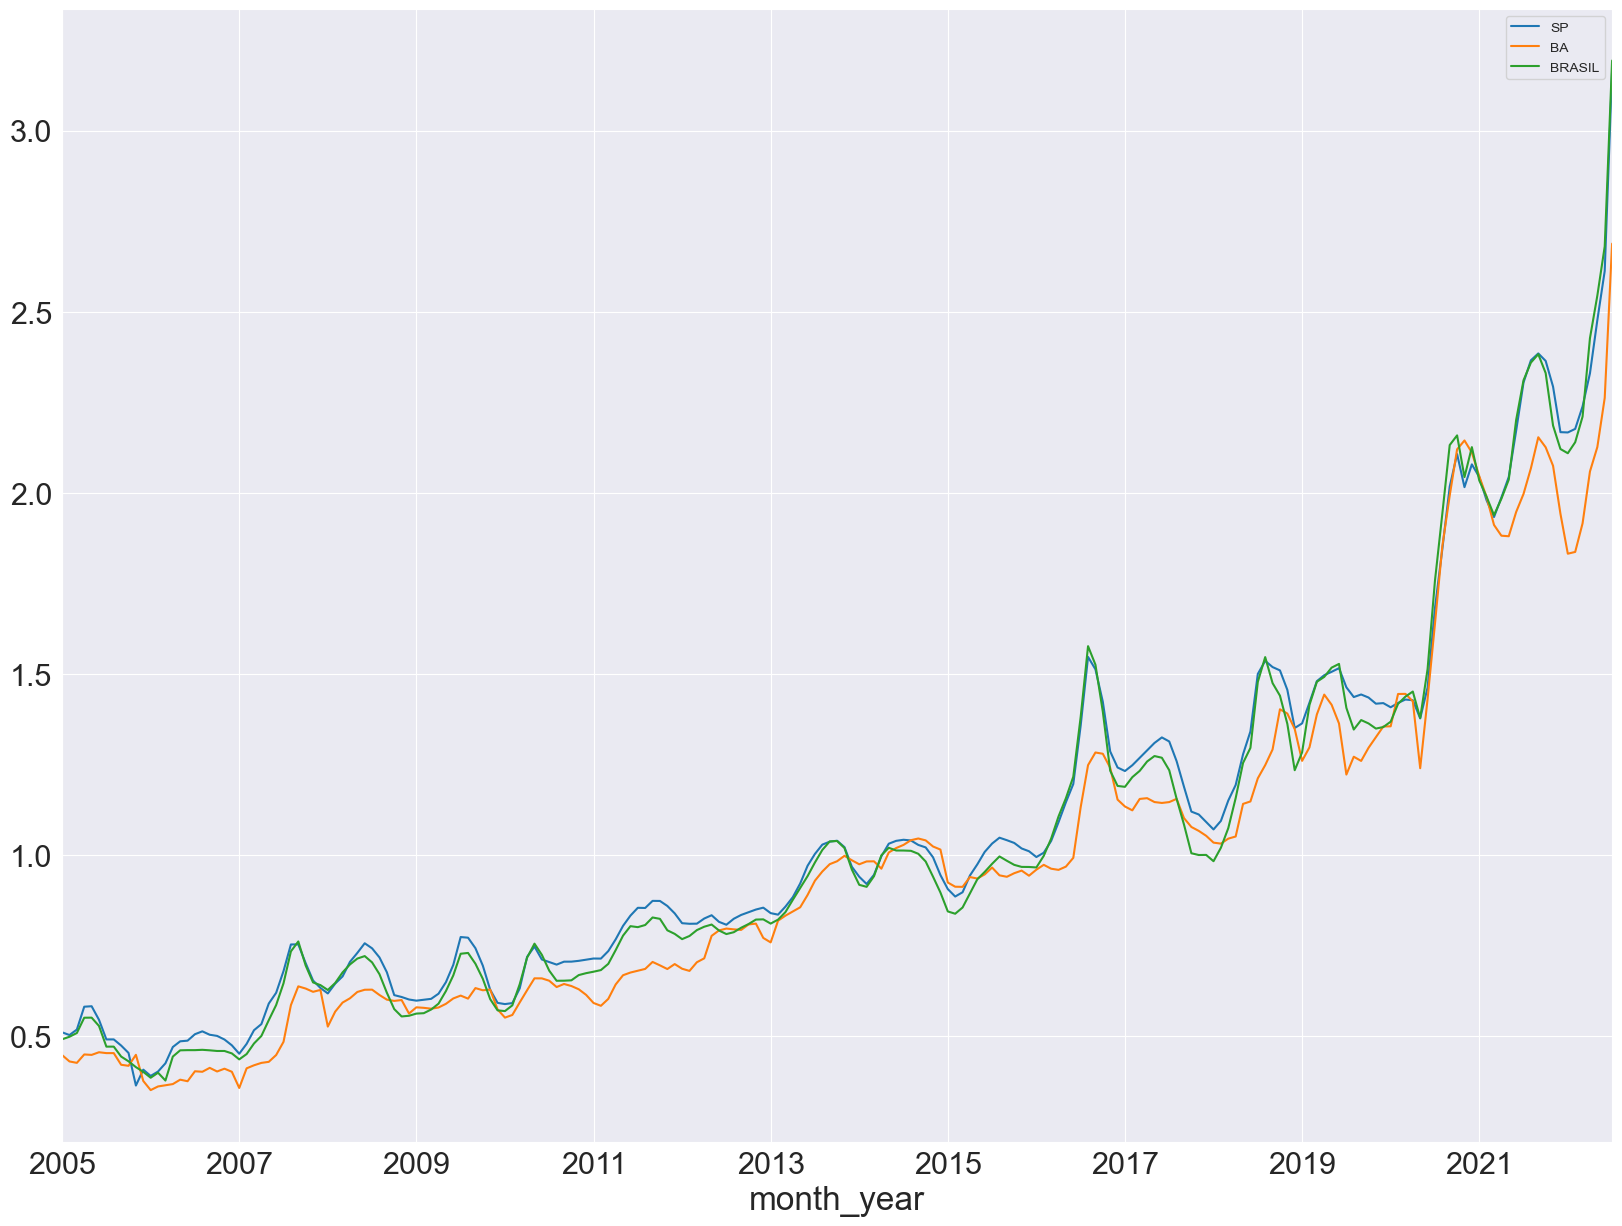

In [34]:
plot_timeseries(df,\
    states=['SP', 'BA', 'BRASIL'],\
         plot_value='average price',\
             column_name='state')

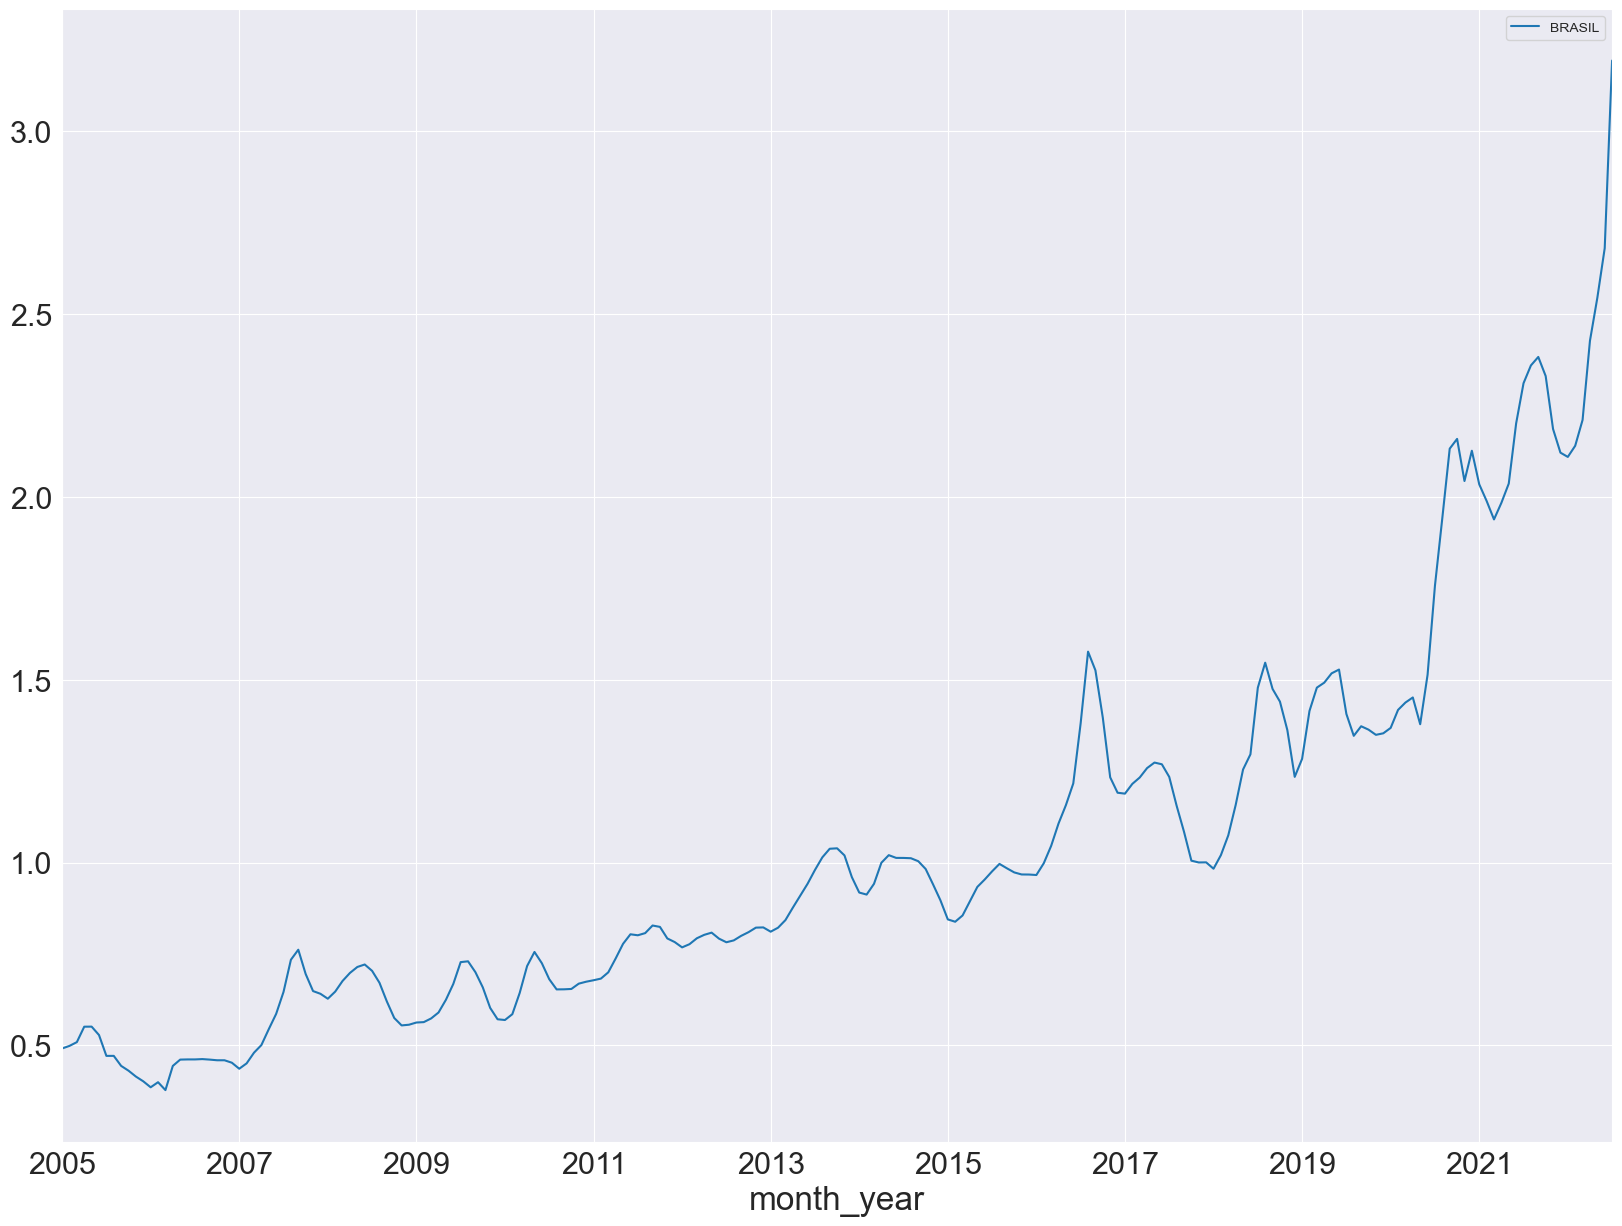

In [35]:
plot_timeseries(df,\
    states=['BRASIL'],\
         plot_value='average price',\
             column_name='state')

In [36]:
df_analytical = create_analytical_columns(df=df, column_based='average price', state='BRASIL', column_state='state')
df_analytical

,year,month,state,lowest average price,average price,highest average price,accumulated_sum_of_price,diff_of_price,moving_average_3m,moving_average_5m,seasonal,trend
month_year,,,,,,,,,,,,
2005-01-01,2005,1,BRASIL,0.3470,0.4916,0.5844,0.4916,NaN,NaN,NaN,-0.075446,NaN
2005-02-01,2005,2,BRASIL,0.3190,0.4987,0.5927,0.9903,0.0071,NaN,NaN,-0.055497,NaN
2005-03-01,2005,3,BRASIL,0.4418,0.5090,0.5536,1.4993,0.0103,0.499767,NaN,-0.043063,NaN
2005-04-01,2005,4,BRASIL,0.4844,0.5512,0.5967,2.0505,0.0422,0.519633,NaN,-0.014396,NaN
2005-05-01,2005,5,BRASIL,0.4929,0.5514,0.5952,2.6019,0.0002,0.537200,0.52038,0.004590,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,2022,3,BRASIL,1.9517,2.2104,2.3746,208.3686,0.0707,2.153133,2.15322,-0.043063,NaN
2022-04-01,2022,4,BRASIL,2.1561,2.4269,2.5895,210.7955,0.2165,2.259000,2.20146,-0.014396,NaN
2022-05-01,2022,5,BRASIL,2.2549,2.5444,2.6962,213.3399,0.1175,2.393900,2.28614,0.004590,NaN


In [37]:
df_analytical.columns

Index(['year', 'month', 'state', 'lowest average price', 'average price',
       'highest average price', 'accumulated_sum_of_price', 'diff_of_price',
       'moving_average_3m', 'moving_average_5m', 'seasonal', 'trend'],
      dtype='object')

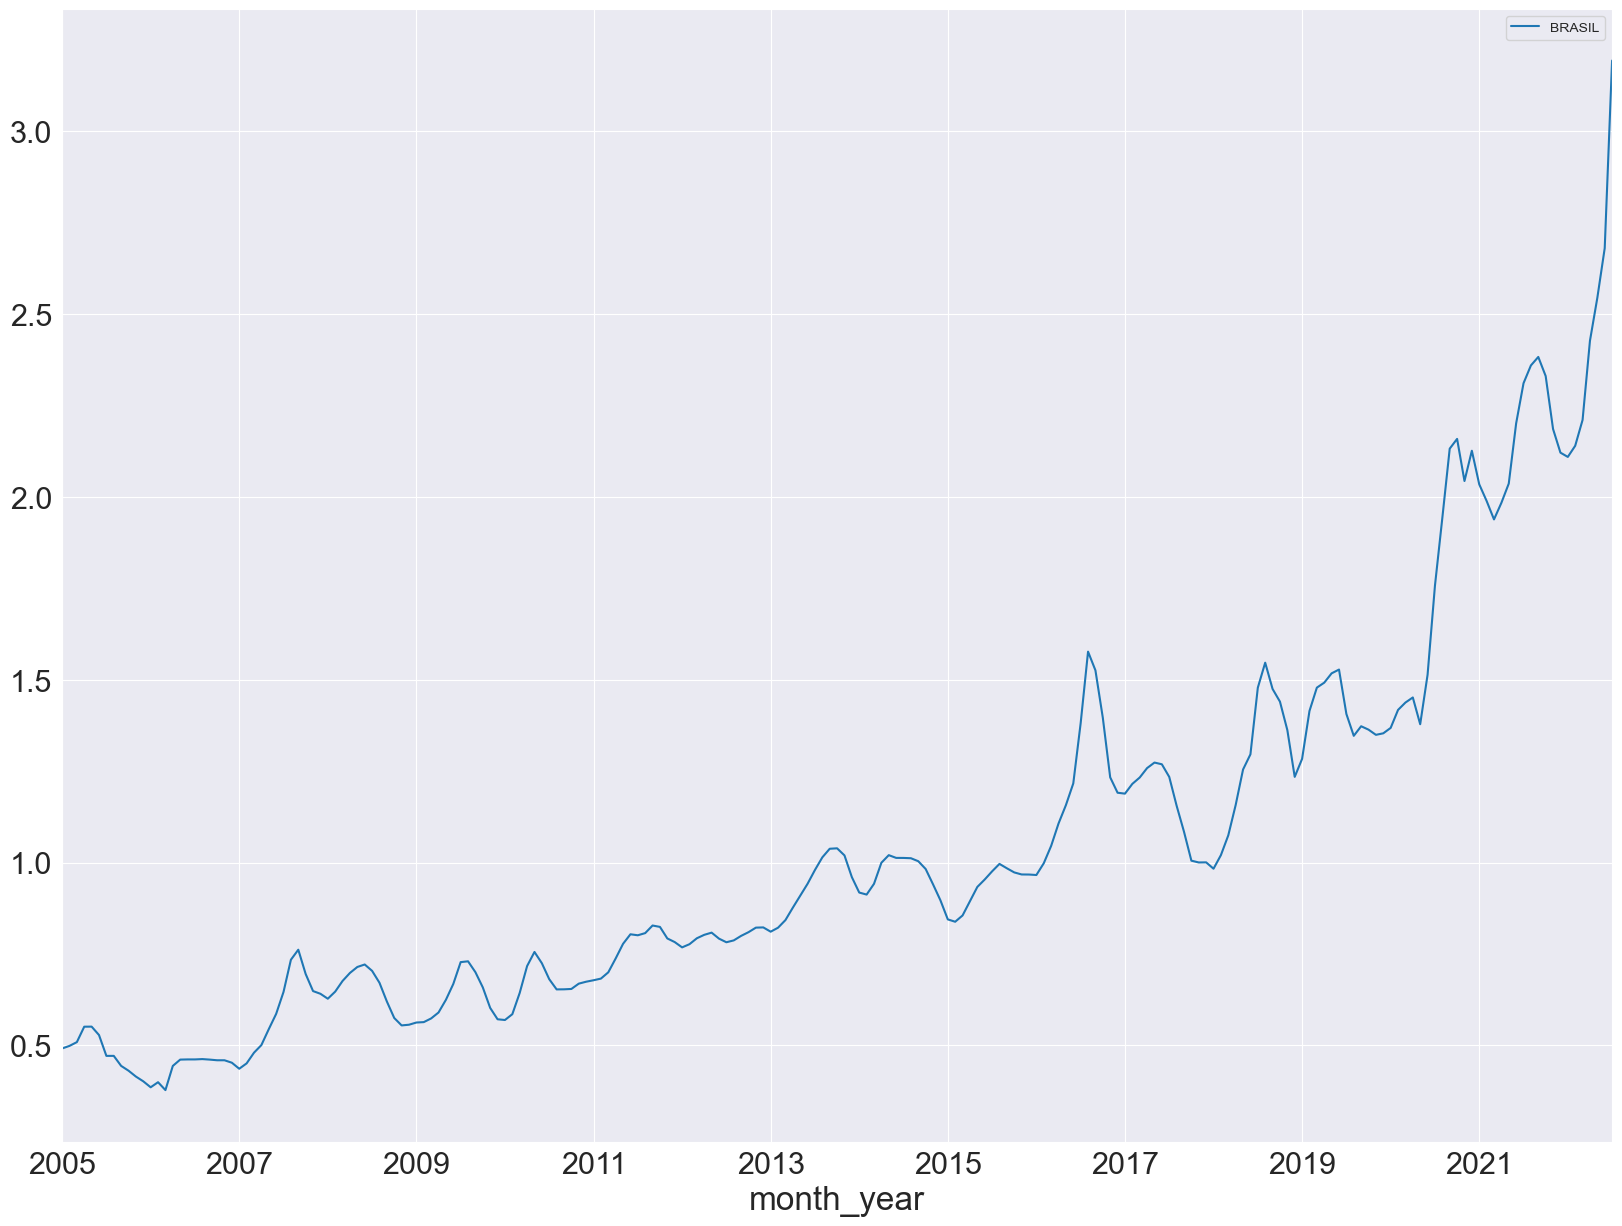

In [38]:
plot_timeseries(df=df_analytical, states=['BRASIL'], plot_value='average price',column_name='state' )

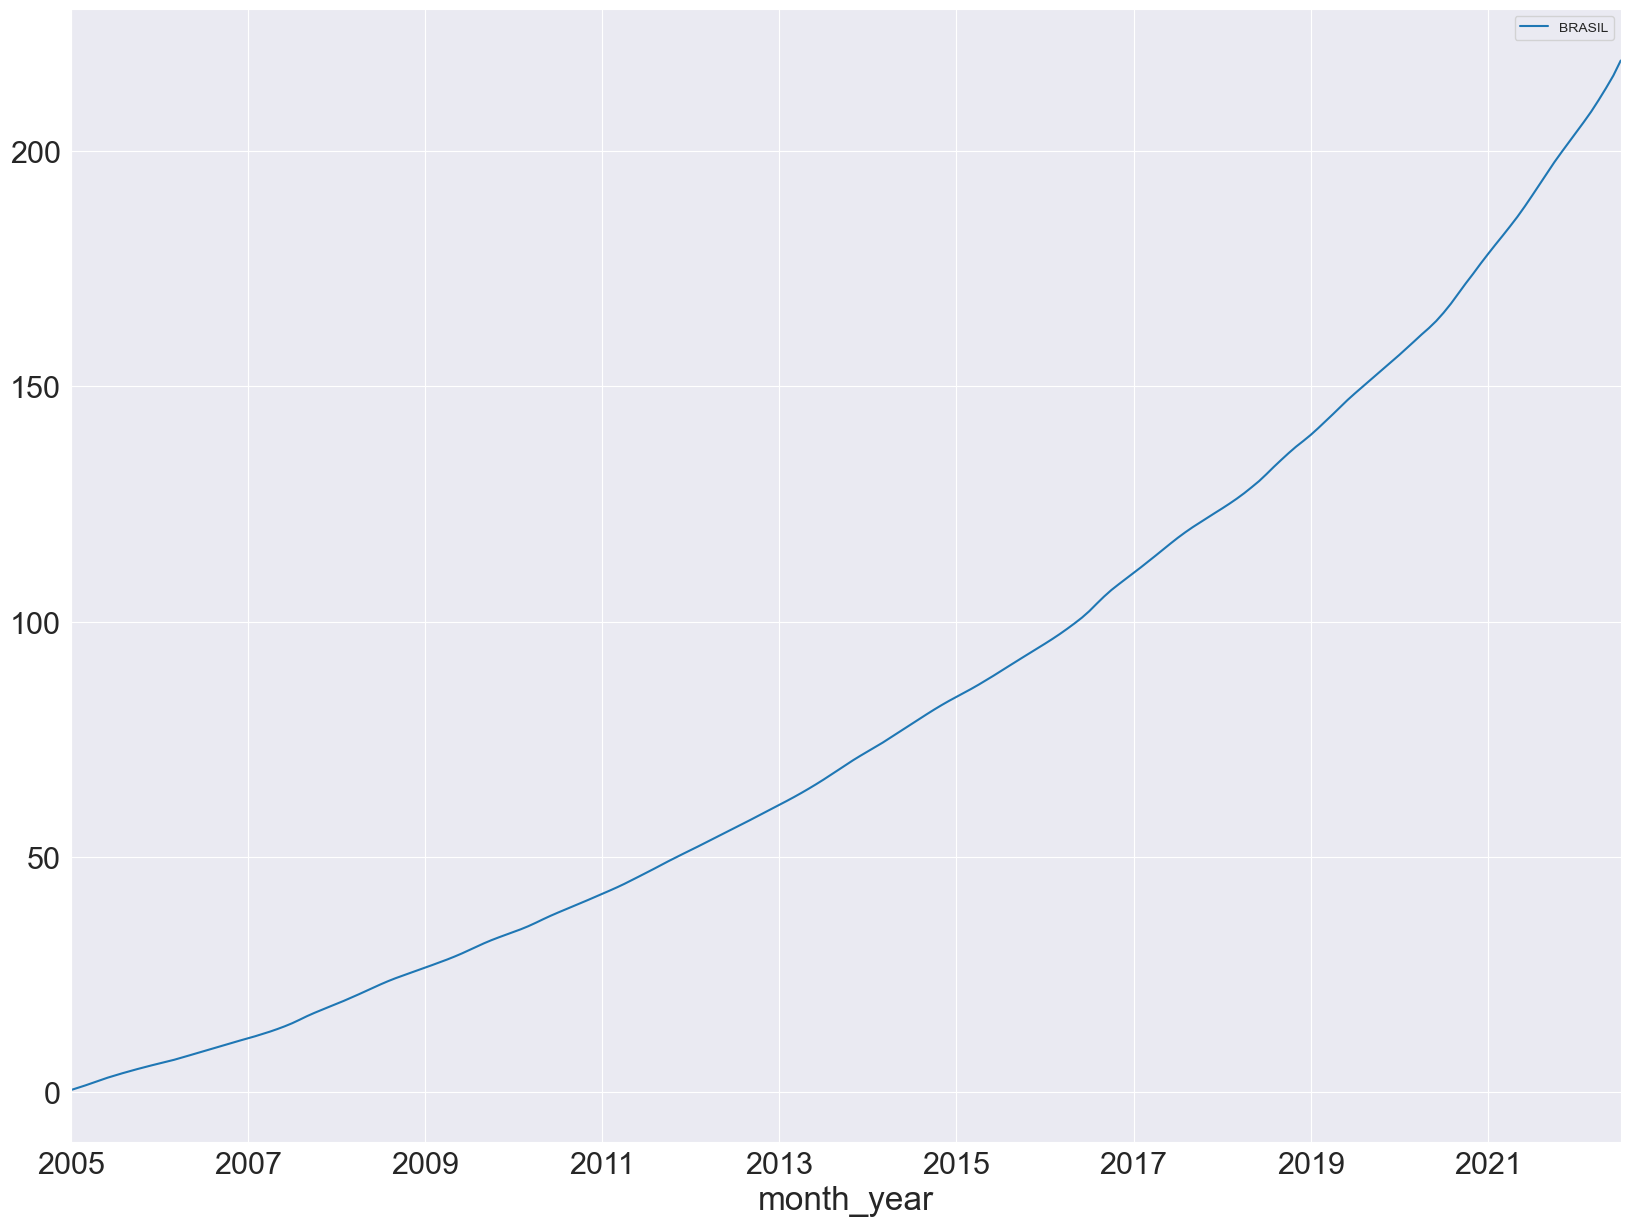

In [39]:
plot_timeseries(df=df_analytical, states=['BRASIL'], plot_value='accumulated_sum_of_price',column_name='state' )

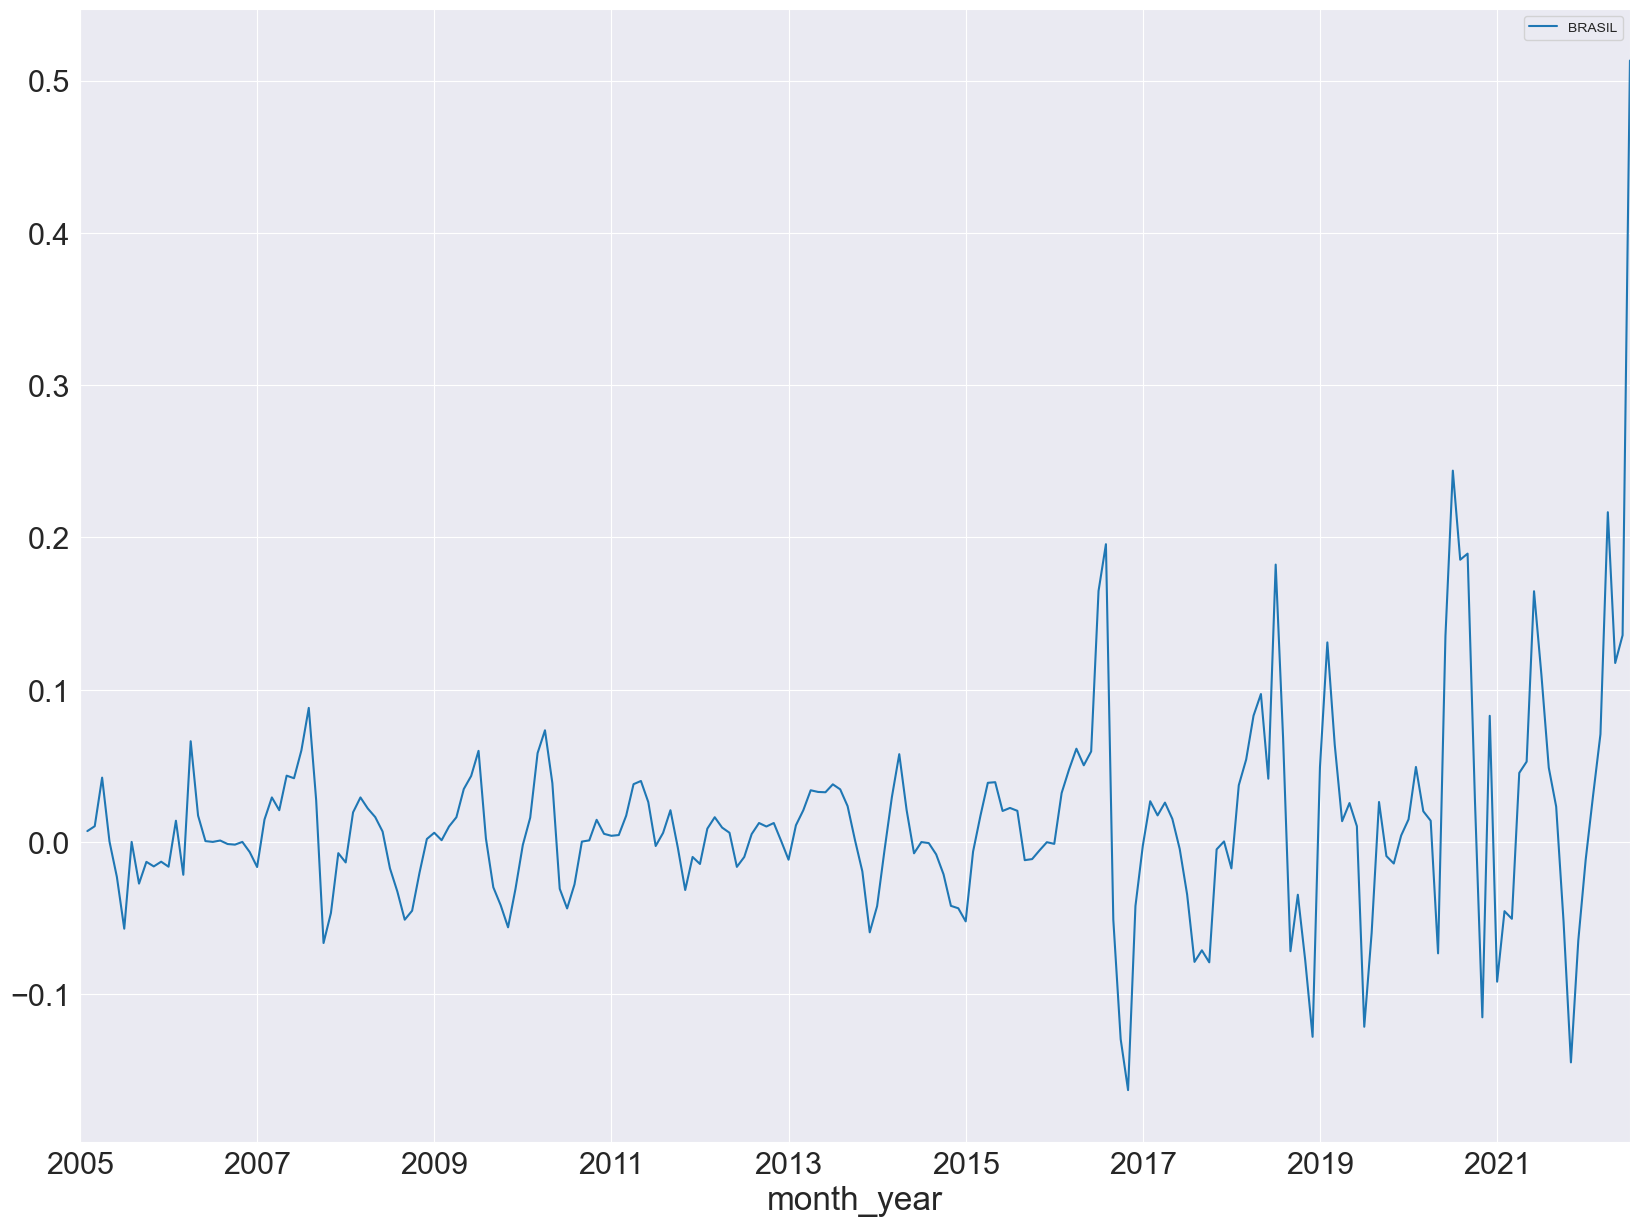

In [40]:
plot_timeseries(df=df_analytical, states=['BRASIL'], plot_value='diff_of_price',column_name='state' )

In [ ]:
plot_timeseries(df=df_analytical, states=['BRASIL'], plot_value='diff_of_price',column_name='state' )